In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pcw_regrs_py as pr
import pycw_fn

# define a basic timeseries sample
times = np.linspace(0, 10)
values = np.hstack([5*times[:10]**2, times[10:30] - 10, (-times[30:] **
                    4 + times[30:]**3 + 10)/np.amax(-times[30:]**4 + times[30:]**3 + 10)])
sample = pr.TimeSeriesSample(times, values)

# Using the basic interface

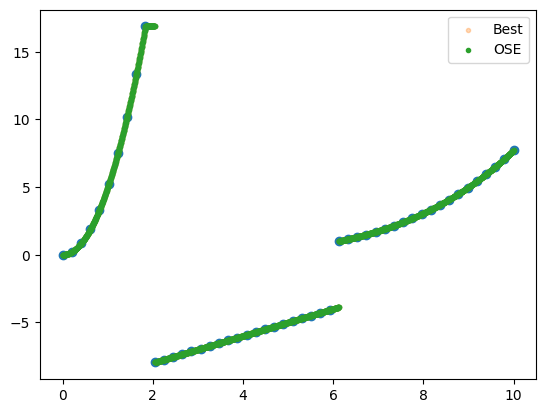

In [2]:
# fit with one standard error rule
p1 = pr.PcwPolynomial.fit_ose(sample)
# fit global minimizer of cv score
p2 = pr.PcwPolynomial.fit_n_best(sample)[0]
# fit with X standard error rule for X = 2
p3 = pr.PcwPolynomial.fit_xse(sample, xse_factor=2.0)
# fit with fixed penalty γ = 0.1
p4 = pr.PcwPolynomial.fit_with_penalty(sample, 0.1)

ts = np.linspace(0, 10, 3000)
plt.scatter(times, values)
plt.scatter(ts, p2(ts), label="Best", marker=".", alpha=0.3)
plt.scatter(ts, p1(ts), label="OSE", marker=".")
plt.legend()
plt.show()

# Using the "advanced" Python interface

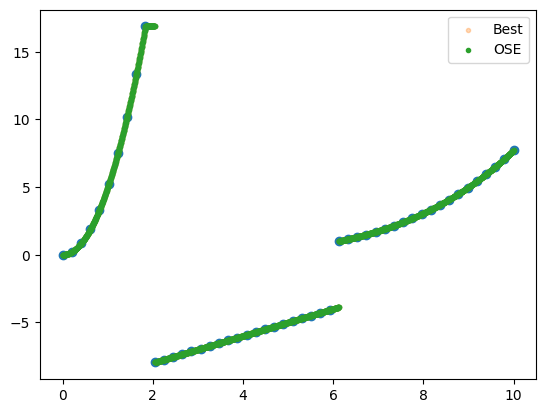

In [3]:
# set user parameters
max_total_dof = 200
max_segment_degree = 10

# compute the full solution using the python interface
sol = pr.Solution.fit(
    sample,
    max_total_dof,
    max_segment_degree + 1 if max_segment_degree is not None else None,
    weights=None
)

# plot the same models as with the simple interface
plt.scatter(times, values)
plt.scatter(ts, sol.n_best()[0](ts), label="Best", marker=".", alpha=0.3)
plt.scatter(ts, sol.ose()(ts), label="OSE", marker=".")
plt.legend()
plt.show()

The advanced interface is more efficient if multiple models should be selected:

In [12]:
from time import time

n_time_samples = 10
t1 = time()
for i in range(n_time_samples):
    p1 = pr.PcwPolynomial.fit_ose(sample)
    p2 = pr.PcwPolynomial.fit_n_best(sample)[0]
    p3 = pr.PcwPolynomial.fit_xse(sample, xse_factor=2.0)
    p4 = pr.PcwPolynomial.fit_with_penalty(sample, 0.1)
t2 = time()
for i in range(n_time_samples):
    sol = pr.Solution.fit(sample)
    p1 = sol.ose()
    p2 = sol.n_best()[0]
    p3 = sol.xse(xse_factor=2.0)
    p4 = sol.with_penalty(0.1)
t3 = time()
print(f"Time for 4 models using basic interface: {(t2-t1) / n_time_samples * 100:.4}ms")
print(f"Time for 4 models using advanced interface: {(t3-t2) / n_time_samples * 100:.4}ms")

Time for 4 models using basic interface: 16.89ms
Time for 4 models using advanced interface: 4.271ms


## Creating a CV plot

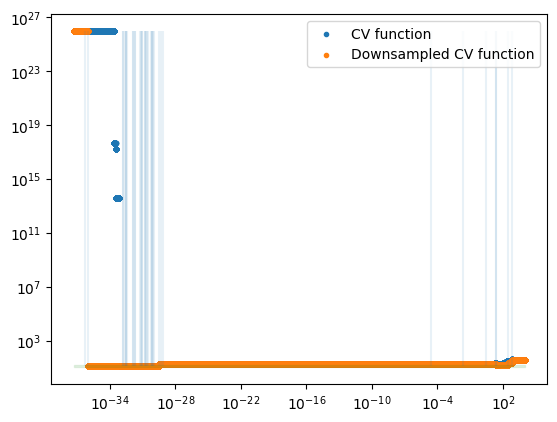

In [23]:
# the loop is just so we get both the inline and the widget plot
for i in range(2):
    if i % 2 == 0:
        pass
        %matplotlib inline
    else:
        pass
        %matplotlib widget

    # access the cv function
    cv_func = sol.cv_func
    dcv_func = sol.downsampled_cv_func
    # generate some sample locations for the CV function for plotting
    gammas = np.logspace(np.log10(min(cv_func.jump_points[0], dcv_func.jump_points[0])) - 1, np.log10(
        max(cv_func.jump_points[-1], dcv_func.jump_points[-1])) + 1, num=100_000)

    # draw both functions
    plt.scatter(gammas, cv_func(gammas), marker=".", label="CV function")
    plt.scatter(gammas, sol.downsampled_cv_func(gammas),
                marker=".", label="Downsampled CV function")
    # add vertical lines at all points where the solution changes
    plt.vlines(sol.downsampled_cv_func.jump_points, ymin=np.amin(
        cv_func.values), ymax=np.amax(cv_func.values), alpha=0.1)

    # determine minimal cv score and corresponding standard error
    idx_min = np.argmin(dcv_func.values)
    cv_min = dcv_func.values[idx_min]
    se_min = sol.downsampled_cv_se_func.values[idx_min]

    # draw shaded vertical strip showing standard error
    plt.fill_between([gammas[0], gammas[-1]], [cv_min - se_min]
                    * 2, [cv_min + se_min] * 2, color="green", alpha=0.1)

    plt.yscale("log", base=10)
    plt.xscale("log", base=10)
    plt.legend()
    plt.show()

# Using the native interface

In [6]:
pr_native = pr._rs

# compute the full solution using the native interface
sol = pr_native.fit_pcw_poly(
    sample.sample_times,
    sample.values,
    max_total_dof,
    max_segment_degree + 1 if max_segment_degree is not None else None,
    weights=None,
)

# acces the function mapping penalties to corresponding solutions of penalized partition problem
model_func = sol.model_func()
print(model_func.jump_points)
models = model_func.values

# the model corresponding to the leftmost gamma segment
m = models[0]
print(m)
# can be easily converted into a piecewise polynomial python object
m_as_pcw_poly = pr.PcwPolynomial.from_data_and_model(sample, m)
# or processed directly:
print(m.cv_score)  # score of model
print(m.cut_idxs)  # "changepoints" as indices into the timeseries
print(m.model_params)  # list of model parameters

[4.98433882e-37 9.23584625e-37 1.57628008e-33 1.69786382e-33
 2.49685276e-33 3.16021462e-33 3.25396762e-33 3.93785705e-33
 1.32925557e-32 1.45938140e-32 1.98979634e-32 2.05275026e-32
 5.59514438e-32 6.68826065e-32 8.56734400e-32 9.25230479e-32
 1.55146313e-31 1.78054198e-31 2.12526369e-31 2.75022796e-31
 3.46140972e-31 5.92312082e-31 6.89290327e-31 7.24089814e-31
 8.30704909e-31 1.11578751e-30 3.15544362e-30 5.16072188e-30
 8.01706858e-30 2.38293769e-05 2.29093307e-02 3.05626180e+00
 2.28975814e+01 2.45282812e+01 2.89797514e+02 6.96343859e+02]
ScoredPolyModel { cv_score: 9.123628319359079e25, cut_idxs: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48], model_params: [PolyModelSpec { start_idx: 0, stop_idx: 3, degrees_of_freedom: 3 }, PolyModelSpec { start_idx: 4, stop_idx: 4, degrees_of_freedom: 1 }, PolyModelSpec { start_idx: 5, stop_idx: 5, degrees_of_freedo